```{contents}
```
## **Reinforcement Feedback in LangGraph**

**Reinforcement feedback** in LangGraph is the mechanism by which **runtime outcomes influence future decisions inside a stateful execution graph**.
It allows LangGraph systems to **improve behavior across steps, across loops, and across sessions** by using rewards, penalties, critiques, and human feedback as part of the graph’s evolving state.

---

### **1. Core Intuition**

LangGraph treats feedback as **first-class state**.

> **Action → Outcome → Feedback → State Update → Improved Next Action**

This converts a static workflow into an **adaptive control system**.

---

### **2. Feedback Lifecycle in LangGraph**

```
Decision → Action → Observation → Evaluation → Feedback → State Update → Next Decision
```

| Phase       | Role                      |
| ----------- | ------------------------- |
| Decision    | Choose next step          |
| Action      | Execute LLM / tool        |
| Observation | Capture result            |
| Evaluation  | Score or critique         |
| Feedback    | Generate reward / penalty |
| Update      | Modify state              |
| Next        | Improved routing          |

---

### **3. Types of Reinforcement Feedback**

| Type                 | Source            | Purpose                 |
| -------------------- | ----------------- | ----------------------- |
| Reward               | Automated metrics | Encourage good behavior |
| Penalty              | Error signals     | Discourage mistakes     |
| Critique             | LLM self-eval     | Improve reasoning       |
| Human Feedback       | User input        | Align with intent       |
| Environment Feedback | Tool results      | Ground decisions        |
| Long-Term Feedback   | Memory            | Behavioral learning     |

---

### **4. Representing Feedback in State**

```python
class State(TypedDict):
    task: str
    answer: str
    score: float
    critique: str
    satisfied: bool
```

Feedback becomes part of the **control signal**.

---

### **5. Feedback-Driven Routing**

```python
def feedback_router(state):
    if state["score"] > 0.8:
        return END
    return "revise"
```

```python
builder.add_conditional_edges("evaluate", feedback_router, {
    "revise": "revise",
    END: END
})
```

---

### **6. Minimal Working Example**

```python
from langgraph.graph import StateGraph, END
from typing import TypedDict

class State(TypedDict):
    draft: str
    score: float

def generate(state):
    return {"draft": "Initial answer"}

def evaluate(state):
    score = 0.5 if "error" in state["draft"] else 0.9
    return {"score": score}

def revise(state):
    return {"draft": state["draft"] + " (improved)"}

builder = StateGraph(State)

builder.add_node("generate", generate)
builder.add_node("evaluate", evaluate)
builder.add_node("revise", revise)

builder.set_entry_point("generate")
builder.add_edge("generate", "evaluate")

builder.add_conditional_edges("evaluate",
    lambda s: END if s["score"] > 0.8 else "revise",
    {"revise": "revise", END: END}
)

builder.add_edge("revise", "evaluate")

graph = builder.compile()
print(graph.invoke({}))
```

This produces a **self-improving loop**.

---

### **7. Human-in-the-Loop Reinforcement**

```python
def human_review(state):
    user_score = float(input("Score this answer (0–1): "))
    return {"score": user_score}
```

Human feedback becomes the **reinforcement signal**.

---

### **8. Long-Term Reinforcement via Memory**

Feedback can be stored:

* Vector memory (retrieval bias)
* Preference store
* User profile
* Policy store

Future executions are **conditioned on past feedback**.

---

### **9. Production Applications**

| System                 | Use                            |
| ---------------------- | ------------------------------ |
| Autonomous agents      | Self-correcting behavior       |
| Customer support bots  | Continuous quality improvement |
| Recommendation engines | Preference alignment           |
| Research assistants    | Progressive refinement         |
| Decision systems       | Risk minimization              |

---

### **10. Why This Matters**

Reinforcement feedback transforms LangGraph from:

> **Workflow engine → Learning control system**

Enabling:

* Adaptation
* Stability
* Reliability
* Autonomy
* Alignment with users

---

### **11. Conceptual Summary**

LangGraph reinforcement feedback is not RL training.
It is **online control learning inside the execution graph**.

> **Behavior improves because feedback reshapes the future execution path.**


### Demonstration

In [1]:
from langgraph.graph import StateGraph, END
from typing import TypedDict

# ---------------------------
# 1. Define shared state
# ---------------------------
class State(TypedDict):
    draft: str
    score: float
    iteration: int

# ---------------------------
# 2. Nodes
# ---------------------------
def generate(state):
    return {"draft": "This is the initial answer.", "iteration": 1}

def evaluate(state):
    # Simple automated feedback rule
    score = 0.4 if "improved" not in state["draft"] else 0.95
    return {"score": score}

def revise(state):
    improved = state["draft"] + " Improved."
    return {
        "draft": improved,
        "iteration": state["iteration"] + 1
    }

# ---------------------------
# 3. Routing based on feedback
# ---------------------------
def feedback_router(state):
    if state["score"] > 0.8 or state["iteration"] >= 5:
        return END
    return "revise"

# ---------------------------
# 4. Build cyclic graph
# ---------------------------
builder = StateGraph(State)

builder.add_node("generate", generate)
builder.add_node("evaluate", evaluate)
builder.add_node("revise", revise)

builder.set_entry_point("generate")
builder.add_edge("generate", "evaluate")

builder.add_conditional_edges(
    "evaluate",
    feedback_router,
    {"revise": "revise", END: END}
)

builder.add_edge("revise", "evaluate")

graph = builder.compile()

# ---------------------------
# 5. Execute
# ---------------------------
final_state = graph.invoke({})
print(final_state)


{'draft': 'This is the initial answer. Improved. Improved. Improved. Improved.', 'score': 0.4, 'iteration': 5}


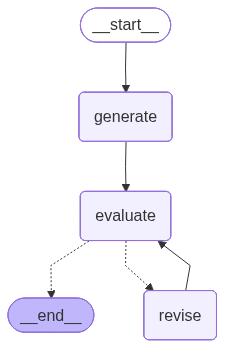

In [2]:
from IPython.display import Image
Image(graph.get_graph().draw_mermaid_png())